In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import tensorflow as tf
from tqdm.keras import TqdmCallback

sns.set_theme()

try: # are we in Colab?
    import google.colab
    COMPUTE_ENV = 'colab'
    print('Running in Colab.')
    #google.colab.drive.mount('/content/gdrive')
    #os.chdir('/content/gdrive/My Drive/projects/xxx')
    !git clone https://github.com/FriedChips/dl_basics.git
    sys.path.insert(0,'/content/dl_basics')
except: # if not...
    if "kaggle" in os.environ["PWD"]: # are we in Kaggle?
        COMPUTE_ENV = 'kaggle'
        print('Running in Kaggle.')
    else: # we're local
        COMPUTE_ENV = os.uname()[1]
        print(f"Running locally on {COMPUTE_ENV}.")
        sys.path.insert(0,'./../')

for gpu in tf.config.list_physical_devices("GPU"):
    print(f"Found GPU: {tf.config.experimental.get_device_details(gpu)['device_name']}.")

Running in Colab.
Cloning into 'dl_basics'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 12 (delta 0), reused 12 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), 263.25 KiB | 1.07 MiB/s, done.
Found GPU: Tesla T4.


In [2]:
from data_gen.synth_sequences import SynthMathData
from models.rnn import build_model_gru_01

In [3]:
P = {
    "batch_size" : 32,
    "seq_len" : 32,
    "operation" : "add",
    "distribution" : "normal",
}

data_gen = SynthMathData(P["batch_size"], P["seq_len"], P["operation"], P["distribution"], seed=42)
x, y = data_gen.__getitem__(1)
print(x.shape, x.dtype, y.shape, y.dtype)

(32, 32, 2) float32 (32,) float32


In [14]:
# init new run

model = build_model_gru_01(
    gru_units=128,
    num_outputs=1,
    input_shape=(P["seq_len"], 2),
    num_hidden_gru=2,
    use_embedding=False,
    #vocab_size=256,
    #embedding_dim=64
)

model.compile(
    loss = "mse",
    optimizer = "adam",
)

model.summary()

P["current_epoch"] = 0
train_history = None

Model: "gru_01"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 2)]           0         
                                                                 
 gru_0 (GRU)                 (None, 32, 128)           50688     
                                                                 
 gru_1 (GRU)                 (None, 32, 128)           99072     
                                                                 
 gru_final (GRU)             (None, 128)               99072     
                                                                 
 linear_final (Dense)        (None, 1)                 129       
                                                                 
Total params: 248,961
Trainable params: 248,961
Non-trainable params: 0
_________________________________________________________________


In [19]:
NUM_EPOCHS = 1024

history = model.fit(
    data_gen,
    initial_epoch = P["current_epoch"],
    epochs = P["current_epoch"] + NUM_EPOCHS,
    callbacks=[
        TqdmCallback(verbose=0),
    ],        
    verbose=0)

P["current_epoch"] += NUM_EPOCHS

train_history = pd.concat([train_history, pd.DataFrame(history.history)], ignore_index=True)
train_history["epoch"] = train_history.index + 1
train_history = train_history.set_index("epoch")
#train_history.to_csv(f"./train_history_fold_{fold}.csv")


0epoch [00:00, ?epoch/s]

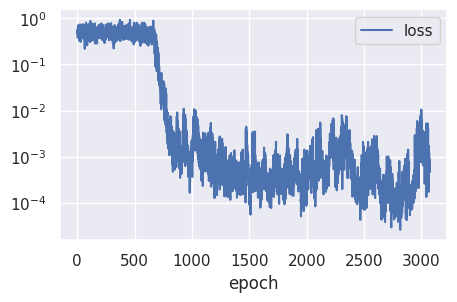

In [20]:
fig, ax = plt.subplots(1,1, figsize=(5,3))

#ax.set_title(f"fold {fold}")

sns.lineplot(data=train_history[["loss"]], ax=ax, dashes=False);
ax.set_yscale("log")

    #sns.lineplot(data=hist[["accuracy", "val_accuracy"]], ax=axs[1,fold], dashes=False);